In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import preprocessor as p
from transformers import XLMModel, BertTokenizer, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification, XLNetTokenizer, XLNetForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel, DebertaForSequenceClassification
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [4]:
MAX_LEN = 256

# Soft

In [11]:
#long_covid
test_df = pd.read_csv('long_covid1003_unique_test.csv', encoding= 'unicode_escape')
print(f'Total shape : {test_df.shape}\nLabel distribution : \n\t0:{test_df.shape[0]-test_df.label.values.sum()}\n\t1:{test_df.label.values.sum()}')

Total shape : (293, 3)
Label distribution : 
	0:57
	1:236


In [12]:
test_sentences = test_df.tweet.values
test_labels = test_df.label.values
#print(test_sentences)

In [13]:
Deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=False)
Roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=False)
XLNet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)
#tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=True)

In [14]:
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [15]:
Deberta_test_token_ids,Deberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Deberta_tokenizer))
Roberta_test_token_ids,Roberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Roberta_tokenizer))
XLNet_test_token_ids,XLNet_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,XLNet_tokenizer))
test_labels = torch.tensor(test_labels)

In [16]:
batch_size = 32

Deberta_test_data = TensorDataset(Deberta_test_token_ids, Deberta_test_attention_masks, test_labels)
Roberta_test_data = TensorDataset(Roberta_test_token_ids, Roberta_test_attention_masks, test_labels)
XLNet_test_data = TensorDataset(XLNet_test_token_ids, XLNet_test_attention_masks, test_labels)

Deberta_test_sampler = SequentialSampler(Deberta_test_data)
Roberta_test_sampler = SequentialSampler(Roberta_test_data)
XLNet_test_sampler = SequentialSampler(XLNet_test_data)

Deberta_test_dataloader = DataLoader(Deberta_test_data, sampler=Deberta_test_sampler, batch_size=batch_size)
Roberta_test_dataloader = DataLoader(Roberta_test_data, sampler=Roberta_test_sampler, batch_size=batch_size)
XLNet_test_dataloader = DataLoader(XLNet_test_data, sampler=XLNet_test_sampler, batch_size=batch_size)

In [34]:
# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
pos_probs_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]


    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        #deberta_preds = torch.argmax(deberta_outputs.logits, dim=-1).cpu().numpy()
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        #roberta_preds = torch.argmax(roberta_outputs.logits, dim=-1).cpu().numpy()
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        #xlnet_preds = torch.argmax(xlnet_outputs.logits, dim=-1).cpu().numpy()
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # 將三個模型的預測進行平均
    ensemble_probs = (deberta_probs + roberta_probs + xlnet_probs) / 3  
    preds_batch = np.round(ensemble_probs)
    preds_list.append(preds_batch)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    pos_probs_list.append(ensemble_probs)
    
# 將結果轉換為numpy陣列
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(pos_probs_list)

# 計算各種指標
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印結果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.den

Test Accuracy: 93.17%
Test Precision: 94.63%
Test Recall: 97.03%
Test F1-score: 95.82%
Test AUC: 97.14%


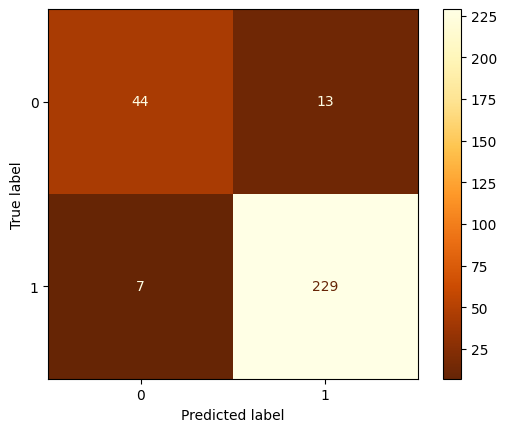

In [16]:
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

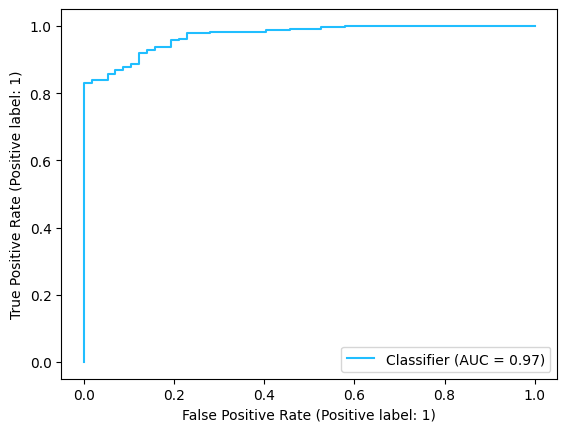

In [17]:
RocCurveDisplay.from_predictions(labels, pos_probs, color='#20BEFF')

# Fuzzy ranks

In [17]:
import math
def fuzzy_rank(CF, top):
    R_L = np.zeros(CF.shape)
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            for k in range(CF.shape[2]):
                R_L[i][j][k] = 1 - math.exp(-math.exp(-2.0*CF[i][j][k]))  #Gompertz Function
                #print(R_L[i][j][k] )
    
    K_L = 0.632*np.ones(shape = R_L.shape) #initiate all values as penalty values
    #print("K_L init: ",K_L)
    for i in range(R_L.shape[0]):
        for sample in range(R_L.shape[1]):
            for k in range(top):
                #print(k)
                a = R_L[i][sample]
                #print(a)
                idx = np.where(a==np.partition(a, k)[k])
                #print(idx)
                #if sample belongs to top 'k' classes, R_L =R_L, else R_L = penalty value
                K_L[i][sample][idx] = R_L[i][sample][idx]
                #print(K_L[i][sample][idx])

    return K_L

def CFS_func(CF, K_L):
    H = CF.shape[0] #no. of classifiers
    for f in range(CF.shape[0]):
        for i in range(CF.shape[1]):
            idx = np.where(K_L[f][i] == 0.632)
            CF[f][i][idx] = 0
    CFS = 1 - np.sum(CF,axis=0)/H
    return CFS

def Gompertz(top = 2, *argv):
    L = 0 #Number of classifiers
    for arg in argv:
        L += 1

    num_classes = arg.shape[1]
    CF = np.zeros(shape = (L,arg.shape[0], arg.shape[1]))

    for i, arg in enumerate(argv):
        CF[:][:][i] = arg

    R_L = fuzzy_rank(CF, top) #R_L is with penalties
    
    RS = np.sum(R_L, axis=0)
    CFS = CFS_func(CF, R_L)
    FS = RS*CFS

    predictions = np.argmin(FS,axis=1)
    return predictions


In [46]:
# 假設有3個模型的預測結果
predictions_model1 = np.array([[0.6, 0.4]])
predictions_model2 = np.array([[0.5, 0.5]])
predictions_model3 = np.array([[0.3, 0.7]])

# 將概率轉換為 fuzzy ranks
CF = np.array([predictions_model1, predictions_model2, predictions_model3])
print("Initial predictions:")
print(CF)
R_L = fuzzy_rank(CF, top=1)
print("Fuzzy Ranks:")
print(R_L)


Initial predictions:
[[[0.6 0.4]]

 [[0.5 0.5]]

 [[0.3 0.7]]]
Fuzzy Ranks:
[[[0.26006595 0.632     ]]

 [[0.30779937 0.30779937]]

 [[0.632      0.21854442]]]


In [47]:
# 計算 CFS
K_L = fuzzy_rank(CF, top=1)
CFS = CFS_func(CF, K_L)

# 計算 Fuzzy Scores
RS = np.sum(R_L, axis=0)
print("RS")
print(RS)
FS = RS * CFS
print("complement of confidence factor sum (CCFS):")
print(CFS)
print("Fuzzy Scores (FS):")
print(FS)

predictions = np.argmin(FS,axis=1)
print(predictions)

RS
[[1.19986532 1.15834379]]
complement of confidence factor sum (CCFS):
[[0.63333333 0.6       ]]
Fuzzy Scores (FS):
[[0.7599147  0.69500627]]
[1]


# Inference top#2

In [91]:
# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
pos_probs_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]


    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        #deberta_preds = torch.argmax(deberta_outputs.logits, dim=-1).cpu().numpy()
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        #roberta_preds = torch.argmax(roberta_outputs.logits, dim=-1).cpu().numpy()
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        #xlnet_preds = torch.argmax(xlnet_outputs.logits, dim=-1).cpu().numpy()
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1).cpu().numpy()

    # 將三個模型的預測進行平均
    fuzzy_preds = []
    fuzzy_FS = []
    for i in range(deberta_probs.shape[0]):
        # 將機率預測轉換為 fuzzy ranks
        CF = np.array([np.array([deberta_probs[i]]), np.array([roberta_probs[i]]), np.array([xlnet_probs[i]])])
        #print(CF)
        R_L = fuzzy_rank(CF, top=2)

        # 計算 CFS
        K_L = fuzzy_rank(CF, top=2)
        CFS = CFS_func(CF, K_L)

        # 計算 Fuzzy Scores
        RS = np.sum(R_L, axis=0)
        #print(RS)
        FS = RS * CFS
        #print("Class Fuzzy Set (CFS):")
        #print(CFS)
        #print("Fuzzy Scores (FS):")
        #print(FS)


        prediction = np.argmin(FS,axis=1)
        fuzzy_preds.append(int(prediction))
        fuzzy_FS.append(FS[0][1])
    preds_list.append(fuzzy_preds)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    pos_probs_list.append(fuzzy_FS)
    
# 將結果轉換為numpy陣列
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(pos_probs_list)

# 計算各種指標
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印結果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classi

Test Accuracy: 93.17%
Test Precision: 94.63%
Test Recall: 97.03%
Test F1-score: 95.82%
Test AUC: 87.11%


In [86]:
np.array([deberta_probs[0]])

array([[4.205968e-05, 9.999579e-01]], dtype=float32)

# Inference top#1

In [13]:
import torch.nn.functional as F

# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
fs_scores_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]

    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1).cpu().numpy()

    # 將三個模型的預測進行平均
    fuzzy_preds = []
    fs_scores = []
    for i in range(deberta_probs.shape[0]):
        # 將機率預測轉換為 fuzzy ranks
        CF = np.array([np.array([deberta_probs[i]]), np.array([roberta_probs[i]]), np.array([xlnet_probs[i]])])
        
        # 計算 fuzzy ranks
        R_L = fuzzy_rank(CF, top=1)

        # 計算 CFS
        K_L = fuzzy_rank(CF, top=1)
        CFS = CFS_func(CF, K_L)

        # 計算 Fuzzy Scores
        RS = np.sum(R_L, axis=0)
        FS = RS * CFS

        prediction = np.argmin(FS, axis=1)
        fuzzy_preds.append(int(prediction))
        
        # 保存 FS 分数用于后续处理
        fs_scores.append(FS)

    preds_list.append(fuzzy_preds)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    fs_scores_list.append(fs_scores)
    
# 将结果转换为numpy数组
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
fs_scores = np.concatenate(fs_scores_list)

# 计算正类概率
fs_scores_tensor = torch.tensor(fs_scores)
pos_probs = F.softmax(fs_scores_tensor, dim=-1)[:,:, 0].numpy()  # 假设第1类是正类

# 计算各种指标
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印结果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

Test Accuracy: 93.52%
Test Precision: 95.02%
Test Recall: 97.03%
Test F1-score: 96.02%
Test AUC: 90.67%


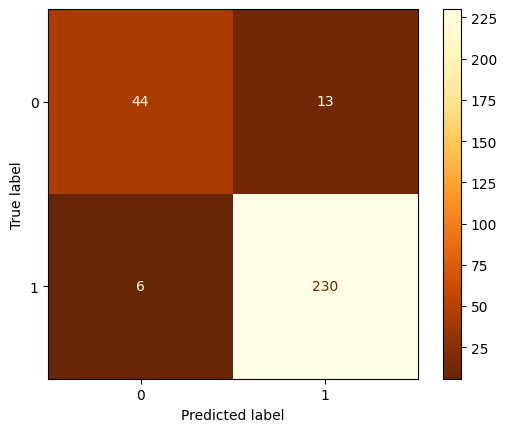

In [42]:
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

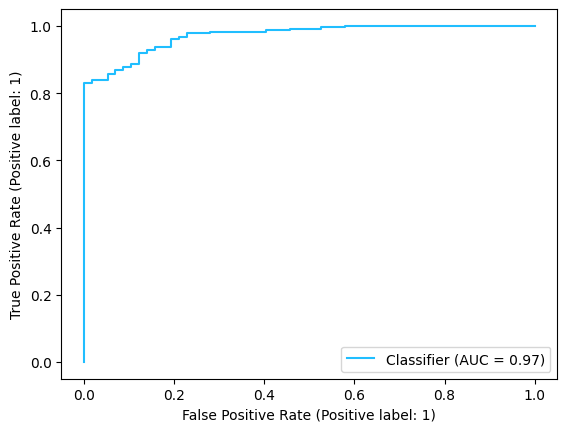

In [43]:
RocCurveDisplay.from_predictions(labels, pos_probs, color='#20BEFF')

In [ ]:
output_df_list = []
for i in preds_list:
    for j in i:
        output_df_list.append(j)
output_df_list

In [128]:
len(output_df_list)

293

In [129]:
prediction_df = pd.DataFrame(output_df_list)
prediction_df.to_csv('test_prediction.csv',index = False)

# Inference sythesis test data

In [187]:
test_df['tweet'].values[11]

'if you have ever eaten at long john silvers you re probably immune to corona'

In [145]:
import re

# 定義函數將句子中的每個單詞替換為'recovery'，但保留標點符號和空格
def replace_with_recovery_keep_punctuation_and_space(sentence):
    # 使用正則表達式將句子分割為單詞和標點符號
    words_and_punctuation = re.findall(r"[\w']+|[.,!?;]", sentence)
    # 使用列表生成式將每個單詞替換為'recovery'，但保留標點符號和空格
    replaced_words = ['recovery' if re.match(r"[\w']+", word) else word for word in words_and_punctuation]
    # 在每個單詞之後添加空格，並將替換後的單詞和標點符號連接為句子
    replaced_sentence = ' '.join(replaced_words)
    return replaced_sentence

# 測試函數
sentence = "Today is a beautiful day."
replaced_sentence = replace_with_recovery_keep_punctuation_and_space(sentence)
print(replaced_sentence)

recovery recovery recovery recovery recovery .


In [146]:
test_df['pseudo_tweet'] = test_df['tweet'].apply(replace_with_recovery_keep_punctuation_and_space)

recovery recovery recovery recovery recovery recovery recovery


In [188]:
test_df['pseudo_tweet'].values[11]

'recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery'

In [157]:
len(test_df['tweet'].values[5].split())

48

In [159]:
print("Text1:\n", test_df['tweet'].values[5])
print("Text2:\n", test_df['pseudo_tweet'].values[5])


Text1:
 2 Chronicles 7:14 King James Version (KJV) 14 If my people, which are called by my name, shall humble themselves, and pray, and seek my face, and turn from their wicked ways; then will I hear from heaven, and will forgive their sin, and will heal their land.
Text2:
 recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery recovery , recovery recovery recovery recovery recovery recovery , recovery recovery recovery , recovery recovery , recovery recovery recovery recovery , recovery recovery recovery recovery recovery recovery ; recovery recovery recovery recovery recovery recovery , recovery recovery recovery recovery recovery , recovery recovery recovery recovery recovery .


In [183]:
testtest = XLNet_tokenizer.tokenize(test_df['pseudo_tweet'].values[4])

In [184]:
np.shape(testtest)

(1317,)

In [ ]:
MAX_LEN = 256

test_sentences = test_df.pseudo_tweet.values
test_labels = test_df.label.values

Deberta_test_token_ids,Deberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Deberta_tokenizer))
Roberta_test_token_ids,Roberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Roberta_tokenizer))
XLNet_test_token_ids,XLNet_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,XLNet_tokenizer))
test_labels = torch.tensor(test_labels)

batch_size = 32

Deberta_test_data = TensorDataset(Deberta_test_token_ids, Deberta_test_attention_masks, test_labels)
Roberta_test_data = TensorDataset(Roberta_test_token_ids, Roberta_test_attention_masks, test_labels)
XLNet_test_data = TensorDataset(XLNet_test_token_ids, XLNet_test_attention_masks, test_labels)

Deberta_test_sampler = SequentialSampler(Deberta_test_data)
Roberta_test_sampler = SequentialSampler(Roberta_test_data)
XLNet_test_sampler = SequentialSampler(XLNet_test_data)

Deberta_test_dataloader = DataLoader(Deberta_test_data, sampler=Deberta_test_sampler, batch_size=batch_size)
Roberta_test_dataloader = DataLoader(Roberta_test_data, sampler=Roberta_test_sampler, batch_size=batch_size)
XLNet_test_dataloader = DataLoader(XLNet_test_data, sampler=XLNet_test_sampler, batch_size=batch_size)

# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
pos_probs_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]


    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        #deberta_preds = torch.argmax(deberta_outputs.logits, dim=-1).cpu().numpy()
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        #roberta_preds = torch.argmax(roberta_outputs.logits, dim=-1).cpu().numpy()
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        #xlnet_preds = torch.argmax(xlnet_outputs.logits, dim=-1).cpu().numpy()
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1).cpu().numpy()

    # 將三個模型的預測進行平均
    fuzzy_preds = []
    fuzzy_FS = []
    for i in range(deberta_probs.shape[0]):
        # 將機率預測轉換為 fuzzy ranks
        CF = np.array([np.array([deberta_probs[i]]), np.array([roberta_probs[i]]), np.array([xlnet_probs[i]])])
        #print(CF)
        R_L = fuzzy_rank(CF, top=1)

        # 計算 CFS
        K_L = fuzzy_rank(CF, top=1)
        CFS = CFS_func(CF, K_L)

        # 計算 Fuzzy Scores
        RS = np.sum(R_L, axis=0)
        #print(RS)
        FS = RS * CFS
        #print("Class Fuzzy Set (CFS):")
        #print(CFS)
        #print("Fuzzy Scores (FS):")
        #print(FS)

        prediction = np.argmin(FS,axis=1)
        fuzzy_preds.append(int(prediction))
        fuzzy_FS.append(FS[0][0])
    preds_list.append(fuzzy_preds)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    pos_probs_list.append(fuzzy_FS)
    
# 將結果轉換為numpy陣列
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(pos_probs_list)

# 計算各種指標
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印結果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [190]:
output_df_list = []
for i in preds_list:
    for j in i:
        output_df_list.append(j)
output_df_list

len(output_df_list)

prediction_df = pd.DataFrame(output_df_list)
prediction_df.to_csv('test_prediction.csv',index = False)

# Real case inference

In [95]:
test_df = pd.read_csv('Real_case_inference0319.csv', encoding= 'unicode_escape')
print(f'Total shape : {test_df.shape}')

Total shape : (4, 6)


In [96]:
test_sentences = test_df.tweet.values
test_labels = test_df.ground_truth.values
#print(test_sentences)

Deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=False)
Roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=False)
XLNet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)
#tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=True)

def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

Deberta_test_token_ids,Deberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Deberta_tokenizer))
Roberta_test_token_ids,Roberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Roberta_tokenizer))
XLNet_test_token_ids,XLNet_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,XLNet_tokenizer))
test_labels = torch.tensor(test_labels)

batch_size = 1

Deberta_test_data = TensorDataset(Deberta_test_token_ids, Deberta_test_attention_masks, test_labels)
Roberta_test_data = TensorDataset(Roberta_test_token_ids, Roberta_test_attention_masks, test_labels)
XLNet_test_data = TensorDataset(XLNet_test_token_ids, XLNet_test_attention_masks, test_labels)

Deberta_test_sampler = SequentialSampler(Deberta_test_data)
Roberta_test_sampler = SequentialSampler(Roberta_test_data)
XLNet_test_sampler = SequentialSampler(XLNet_test_data)

Deberta_test_dataloader = DataLoader(Deberta_test_data, sampler=Deberta_test_sampler, batch_size=batch_size)
Roberta_test_dataloader = DataLoader(Roberta_test_data, sampler=Roberta_test_sampler, batch_size=batch_size)
XLNet_test_dataloader = DataLoader(XLNet_test_data, sampler=XLNet_test_sampler, batch_size=batch_size)

In [98]:
# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
pos_probs_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]


    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        #deberta_preds = torch.argmax(deberta_outputs.logits, dim=-1).cpu().numpy()
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        #roberta_preds = torch.argmax(roberta_outputs.logits, dim=-1).cpu().numpy()
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        #xlnet_preds = torch.argmax(xlnet_outputs.logits, dim=-1).cpu().numpy()
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1).cpu().numpy()

    # 將三個模型的預測進行平均
    fuzzy_preds = []
    fuzzy_FS = []
    for i in range(deberta_probs.shape[0]):
        # 將機率預測轉換為 fuzzy ranks
        CF = np.array([np.array([deberta_probs[i]]), np.array([roberta_probs[i]]), np.array([xlnet_probs[i]])])
        #print(CF)
        R_L = fuzzy_rank(CF, top=1)

        # 計算 CFS
        K_L = fuzzy_rank(CF, top=1)
        CFS = CFS_func(CF, K_L)

        # 計算 Fuzzy Scores
        RS = np.sum(R_L, axis=0)
        #print(RS)
        FS = RS * CFS
        #print("Class Fuzzy Set (CFS):")
        #print(CFS)
        #print("Fuzzy Scores (FS):")
        #print(FS)

        prediction = np.argmin(FS,axis=1)
        fuzzy_preds.append(int(prediction))
        fuzzy_FS.append(FS[0][0])
    preds_list.append(fuzzy_preds)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    pos_probs_list.append(fuzzy_FS)
    
# 將結果轉換為numpy陣列
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(pos_probs_list)

# 計算各種指標
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印結果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier

Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%
Test F1-score: 100.00%
Test AUC: 100.00%


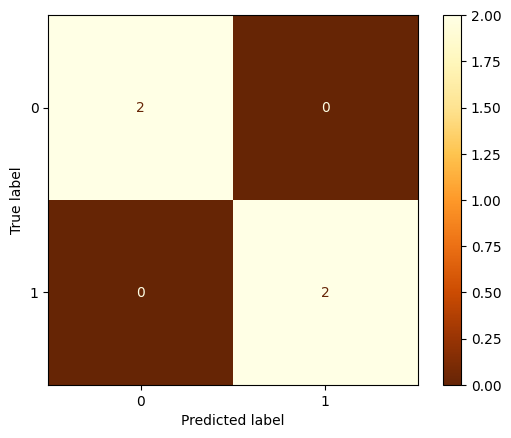

In [38]:
cm = confusion_matrix(labels, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [39]:
preds

array([1, 0, 0, 1])

In [45]:
testtest = XLNet_tokenizer.tokenize(test_df['tweet'][3])
len(testtest)

469

# BertViz

In [ ]:
#pip install bertviz

In [25]:
from bertviz import head_view
BertViz_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)
BertViz_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", output_attentions = True)
BertViz_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# BertViz_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=False)
# BertViz_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", output_attentions = True)
# BertViz_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# BertViz_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=False)
# BertViz_model = RobertaForSequenceClassification.from_pretrained("roberta-base", output_attentions = True)
# BertViz_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

<All keys matched successfully>

In [26]:
inputs = BertViz_tokenizer.encode("A German study has revealed long COVID is linked to the vaccine.", return_tensors='pt')
outputs = BertViz_model(inputs)
attention = outputs.attentions  # Output includes attention weights when output_attentions=True
tokens = BertViz_tokenizer.convert_ids_to_tokens(inputs[0]) 

In [132]:
# DeBERTa
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [24]:
# RoBERTa
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [27]:
# XLNet
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [133]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [18]:
inputs = BertViz_tokenizer.encode("Covid vaccination before infection strongly linked to reduced risk of developing long covid", return_tensors='pt')
outputs = BertViz_model(inputs)
attention = outputs.attentions  # Output includes attention weights when output_attentions=True
tokens = BertViz_tokenizer.convert_ids_to_tokens(inputs[0]) 
head_view(attention, tokens)

<IPython.core.display.Javascript object>

# Output prediction from traning set for feature fusion training.

In [47]:
#long_covid
#test_df = pd.read_csv('fake_news_detection/feature_test.csv', encoding= 'unicode_escape')
test_df = pd.read_csv('long_covid20240602_train_allpredict.csv', encoding= 'unicode_escape')

print(f'Total shape : {test_df.shape}\nLabel distribution : \n\t0:{test_df.shape[0]-test_df.label.values.sum()}\n\t1:{test_df.label.values.sum()}')

test_sentences = test_df.tweet.values
test_labels = test_df.label.values
#print(test_sentences)

Deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=False)
Roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=False)
XLNet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)
#tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=True)

def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

Deberta_test_token_ids,Deberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Deberta_tokenizer))
Roberta_test_token_ids,Roberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Roberta_tokenizer))
XLNet_test_token_ids,XLNet_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,XLNet_tokenizer))
test_labels = torch.tensor(test_labels)

batch_size = 32

Deberta_test_data = TensorDataset(Deberta_test_token_ids, Deberta_test_attention_masks, test_labels)
Roberta_test_data = TensorDataset(Roberta_test_token_ids, Roberta_test_attention_masks, test_labels)
XLNet_test_data = TensorDataset(XLNet_test_token_ids, XLNet_test_attention_masks, test_labels)

Deberta_test_sampler = SequentialSampler(Deberta_test_data)
Roberta_test_sampler = SequentialSampler(Roberta_test_data)
XLNet_test_sampler = SequentialSampler(XLNet_test_data)

Deberta_test_dataloader = DataLoader(Deberta_test_data, sampler=Deberta_test_sampler, batch_size=batch_size)
Roberta_test_dataloader = DataLoader(Roberta_test_data, sampler=Roberta_test_sampler, batch_size=batch_size)
XLNet_test_dataloader = DataLoader(XLNet_test_data, sampler=XLNet_test_sampler, batch_size=batch_size)

# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
pos_probs_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]


    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        #deberta_preds = torch.argmax(deberta_outputs.logits, dim=-1).cpu().numpy()
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        #roberta_preds = torch.argmax(roberta_outputs.logits, dim=-1).cpu().numpy()
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        #xlnet_preds = torch.argmax(xlnet_outputs.logits, dim=-1).cpu().numpy()
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1)[:, 1].cpu().numpy()

    # 將三個模型的預測進行平均
    ensemble_probs = (deberta_probs + roberta_probs + xlnet_probs) / 3  
    preds_batch = np.round(ensemble_probs)
    preds_list.append(preds_batch)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    pos_probs_list.append(ensemble_probs)
    
# 將結果轉換為numpy陣列
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(pos_probs_list)

# 計算各種指標
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印結果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Total shape : (2634, 14)
Label distribution : 
	0:509
	1:2125


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.den

Test Accuracy: 99.43%
Test Precision: 99.58%
Test Recall: 99.72%
Test F1-score: 99.65%
Test AUC: 99.88%


In [7]:
#long_covid
#test_df = pd.read_csv('fake_news_detection/feature_test.csv', encoding= 'unicode_escape')
test_df = pd.read_csv('/fake_news_detection/feature_test_0530.csv', encoding= 'unicode_escape')

print(f'Total shape : {test_df.shape}\nLabel distribution : \n\t0:{test_df.shape[0]-test_df.label.values.sum()}\n\t1:{test_df.label.values.sum()}')

test_sentences = test_df.tweet.values
test_labels = test_df.label.values
#print(test_sentences)

Deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=False)
Roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=False)
XLNet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)
#tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=True)

def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

Deberta_test_token_ids,Deberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Deberta_tokenizer))
Roberta_test_token_ids,Roberta_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,Roberta_tokenizer))
XLNet_test_token_ids,XLNet_test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,XLNet_tokenizer))
test_labels = torch.tensor(test_labels)

batch_size = 32

Deberta_test_data = TensorDataset(Deberta_test_token_ids, Deberta_test_attention_masks, test_labels)
Roberta_test_data = TensorDataset(Roberta_test_token_ids, Roberta_test_attention_masks, test_labels)
XLNet_test_data = TensorDataset(XLNet_test_token_ids, XLNet_test_attention_masks, test_labels)

Deberta_test_sampler = SequentialSampler(Deberta_test_data)
Roberta_test_sampler = SequentialSampler(Roberta_test_data)
XLNet_test_sampler = SequentialSampler(XLNet_test_data)

Deberta_test_dataloader = DataLoader(Deberta_test_data, sampler=Deberta_test_sampler, batch_size=batch_size)
Roberta_test_dataloader = DataLoader(Roberta_test_data, sampler=Roberta_test_sampler, batch_size=batch_size)
XLNet_test_dataloader = DataLoader(XLNet_test_data, sampler=XLNet_test_sampler, batch_size=batch_size)


# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
pos_probs_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]


    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        #deberta_preds = torch.argmax(deberta_outputs.logits, dim=-1).cpu().numpy()
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        #roberta_preds = torch.argmax(roberta_outputs.logits, dim=-1).cpu().numpy()
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        #xlnet_preds = torch.argmax(xlnet_outputs.logits, dim=-1).cpu().numpy()
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1).cpu().numpy()

    # 將三個模型的預測進行平均
    fuzzy_preds = []
    fuzzy_FS = []
    for i in range(deberta_probs.shape[0]):
        # 將機率預測轉換為 fuzzy ranks
        CF = np.array([np.array([deberta_probs[i]]), np.array([roberta_probs[i]]), np.array([xlnet_probs[i]])])
        #print(CF)
        R_L = fuzzy_rank(CF, top=1)

        # 計算 CFS
        K_L = fuzzy_rank(CF, top=1)
        CFS = CFS_func(CF, K_L)

        # 計算 Fuzzy Scores
        RS = np.sum(R_L, axis=0)
        #print(RS)
        FS = RS * CFS
        #print("Class Fuzzy Set (CFS):")
        #print(CFS)
        #print("Fuzzy Scores (FS):")
        #print(FS)

        prediction = np.argmin(FS,axis=1)
        fuzzy_preds.append(int(prediction))
        fuzzy_FS.append(FS[0][0])
    preds_list.append(fuzzy_preds)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    pos_probs_list.append(fuzzy_FS)
    
# 將結果轉換為numpy陣列
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
pos_probs = np.concatenate(pos_probs_list)

# 計算各種指標
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印結果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Total shape : (293, 11)
Label distribution : 
	0:57
	1:236


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.den

Test Accuracy: 93.52%
Test Precision: 94.65%
Test Recall: 97.46%
Test F1-score: 96.03%
Test AUC: 89.96%


In [33]:
FS

array([[1.89600000e+00, 1.64107792e-05]])

In [32]:
preds[10]

0

In [31]:
pos_probs[10]

0.00011035400798252394

In [48]:
test_df['soft_score'] = pos_probs
test_df.head(15)

tweet  label  assertive_verbs   
0   you re immune to the corona virus if you carri...      1         0.000000  \
1   No, Fauci did not admit that COVID-19 vaccines...      1         0.040185   
2   What are you talking about all the immigrants ...      1         0.000000   
3   Fact Check: British Prince Charles Cured Of CO...      1         0.045833   
4   if you ve ever eaten at waffle house you re im...      1         0.000000   
5   these aren t just any cows scientists genetica...      1         0.000000   
6   Wisconsin senator off-base with claim that its...      1         0.040426   
7   Donald Trumps false claim that COVID-19 is les...      1         0.024254   
8   usa nancy pelosi is immune from the corona vir...      1         0.000000   
9   I hope he does beat it for his sake, his famil...      1         0.058824   
10  mayo clinic s dr amy williams joined joe to di...      0         0.000000   
11  the exploding autoimmune epidemic dr tent via ...      1         0.000000   
12  so that they are immune from the virus spreadi...      1         0.000000   
13  q if you ever ordered a hotdog off a truck in ...      1         0.000000   
14  plus prevention is better than cure so protect...      1         0.000000   

    factive_verbs  implicative_verbs    hedges  report_verbs      bias   
0        0.000000           0.000000  0.083333      0.000000  0.250000  \
1        0.006182           0.007728  0.006182      0.078825  0.251932   
2        0.000000           0.000000  0.000000      0.000000  0.300000   
3        0.002083           0.006250  0.018750      0.072917  0.231250   
4        0.000000           0.000000  0.000000      0.000000  0.000000   
5        0.000000           0.000000  0.000000      0.000000  0.363636   
6        0.004255           0.004255  0.031915      0.080851  0.314894   
7        0.005597           0.001866  0.009328      0.054104  0.302239   
8        0.000000           0.000000  0.000000      0.000000  0.375000   
9        0.000000           0.000000  0.058824      0.117647  0.294118   
10       0.000000           0.000000  0.052632      0.052632  0.157895   
11       0.000000           0.000000  0.000000      0.000000  0.200000   
12       0.000000           0.000000  0.000000      0.083333  0.333333   
13       0.000000           0.000000  0.000000      0.222222  0.222222   
14       0.000000           0.037037  0.000000      0.000000  0.296296   

    sectarian_language  quoted_sources  ensemble_score  fuzzy_label   
0             0.000000               0         1.89600            1  \
1             0.000000              -1         1.89600            1   
2             0.000000               0         1.89600            1   
3             0.002083              -1         1.89600            1   
4             0.000000               0         1.89600            1   
5             0.000000               0         1.89600            1   
6             0.000000              -1         1.89600            1   
7             0.000000              -1         1.89600            1   
8             0.000000               0         1.89600            1   
9             0.000000              -1         1.89600            1   
10            0.000000              -1         0.00011            0   
11            0.000000               0         1.89600            1   
12            0.000000              -1         1.89600            1   
13            0.000000              -1         1.89600            1   
14            0.000000               0         1.89600            1   

    XGBoost_score3  XGBoost_score4  soft_score  
0         0.676366        0.323634    0.999942  
1         0.998351        0.001649    0.999954  
2         0.892370        0.107630    0.999772  
3         0.998892        0.001108    0.999954  
4         0.933334        0.066666    0.999943  
5         0.801642        0.198358    0.999920  
6         0.993457        0.006543    0.999949  
7         0.996590        0.003410   

In [42]:
test_df = test_df.drop(['Unnamed: 0'], axis=1)
test_df.head()

tweet  label  assertive_verbs   
0                  ofc albos are immune to the virus      1         0.000000  \
1  No, Pfizer-BioNTech COVID-19 Vaccine Does Not ...      1         0.041262   
2  No truth that VAERS system shows 6,000 died be...      1         0.042105   
3  sinovac says early data show its covid vaccine...      1         0.090909   
4  Trumps Dubious Claim That Hes Not Contagious:L...      1         0.042759   

   factive_verbs  implicative_verbs    hedges  report_verbs      bias   
0       0.000000           0.000000  0.000000      0.000000  0.250000  \
1       0.004854           0.009709  0.031553      0.075243  0.194175   
2       0.000000           0.007018  0.010526      0.070175  0.284211   
3       0.000000           0.000000  0.000000      0.181818  0.181818   
4       0.005517           0.005517  0.030345      0.063448  0.292414   

   sectarian_language  quoted_sources  soft_score  
0                 0.0               0    0.999932  
1                 0.0              -1    0.999959  
2                 0.0              -1    0.999956  
3                 0.0              -1    0.999687  
4                 0.0              -1    0.999948

In [49]:
test_df.to_csv('long_covid20240605_train_allpredict.csv', index = False)

In [9]:
testtest = pd.read_csv('long_covid20240530_test_allpredict.csv',  encoding= 'unicode_escape')
testtest.head()

tweet  label  assertive_verbs   
0                  ofc albos are immune to the virus      1         0.000000  \
1  No, Pfizer-BioNTech COVID-19 Vaccine Does Not ...      1         0.041262   
2  No truth that VAERS system shows 6,000 died be...      1         0.042105   
3  sinovac says early data show its covid vaccine...      1         0.090909   
4  Trumps Dubious Claim That Hes Not Contagious:L...      1         0.042759   

   factive_verbs  implicative_verbs    hedges  report_verbs      bias   
0       0.000000           0.000000  0.000000      0.000000  0.250000  \
1       0.004854           0.009709  0.031553      0.075243  0.194175   
2       0.000000           0.007018  0.010526      0.070175  0.284211   
3       0.000000           0.000000  0.000000      0.181818  0.181818   
4       0.005517           0.005517  0.030345      0.063448  0.292414   

   sectarian_language  quoted_sources  soft_score  XGBoost_score   
0                 0.0               0    0.999932       0.807063  \
1                 0.0              -1    0.999959       0.996602   
2                 0.0              -1    0.999956       0.992963   
3                 0.0              -1    0.999687       0.499547   
4                 0.0              -1    0.999948       0.997296   

   XGBoost_score2  soft_score2  fincal_predict  fincal_score  
0        0.192937     0.000068               0      0.029636  
1        0.003398     0.000041               0      0.000437  
2        0.007037     0.000044               0      0.000902  
3        0.500453     0.000313               0      0.379444  
4        0.002704     0.000052               0      0.000350

In [10]:
testtest['fuzzy_label'] = preds
testtest.to_csv('long_covid20240531_test_allpredict.csv', index = False)

In [41]:
import torch.nn.functional as F

# 載入Deberta模型
deberta_model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
deberta_model.load_state_dict(torch.load('DeBerta_base_best_model_1024.ckpt'))

# 載入RoBERTa模型
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
roberta_model.load_state_dict(torch.load('RoBerta_base_best_model.ckpt'))

# 載入XLNet模型
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased")
xlnet_model.load_state_dict(torch.load('XLNET_base_best_model.ckpt'))

# 將模型移到GPU
deberta_model.to(device)
roberta_model.to(device)
xlnet_model.to(device)

# 將模型設定為評估模式
deberta_model.eval()
roberta_model.eval()
xlnet_model.eval()

# 初始化各種用於存儲預測結果的列表
preds_list = []
labels_list = []
fs_scores_list = []

# 測試數據集
for deberta_batch, roberta_batch, xlnet_batch in zip(Deberta_test_dataloader, Roberta_test_dataloader, XLNet_test_dataloader):
    deberta_input_ids, deberta_attention_mask, deberta_labels_batch = [b.to(device) for b in deberta_batch]
    roberta_input_ids, roberta_attention_mask, roberta_labels_batch = [b.to(device) for b in roberta_batch]
    xlnet_input_ids, xlnet_attention_mask, xlnet_labels_batch = [b.to(device) for b in xlnet_batch]

    # 使用Deberta模型進行預測
    with torch.no_grad():
        deberta_outputs = deberta_model(deberta_input_ids, attention_mask=deberta_attention_mask)
        deberta_probs = torch.nn.functional.softmax(deberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用RoBERTa模型進行預測
    with torch.no_grad():
        roberta_outputs = roberta_model(roberta_input_ids, attention_mask=roberta_attention_mask)
        roberta_probs = torch.nn.functional.softmax(roberta_outputs.logits, dim=-1).cpu().numpy()

    # 使用XLNet模型進行預測
    with torch.no_grad():
        xlnet_outputs = xlnet_model(xlnet_input_ids, attention_mask=xlnet_attention_mask)
        xlnet_probs = torch.nn.functional.softmax(xlnet_outputs.logits, dim=-1).cpu().numpy()

    # 將三個模型的預測進行平均
    fuzzy_preds = []
    fs_scores = []
    for i in range(deberta_probs.shape[0]):
        # 將機率預測轉換為 fuzzy ranks
        CF = np.array([np.array([deberta_probs[i]]), np.array([roberta_probs[i]]), np.array([xlnet_probs[i]])])
        
        # 計算 fuzzy ranks
        R_L = fuzzy_rank(CF, top=1)

        # 計算 CFS
        K_L = fuzzy_rank(CF, top=1)
        CFS = CFS_func(CF, K_L)

        # 計算 Fuzzy Scores
        RS = np.sum(R_L, axis=0)
        FS = RS * CFS

        prediction = np.argmin(FS, axis=1)
        fuzzy_preds.append(int(prediction))
        
        # 保存 FS 分数用于后续处理
        fs_scores.append(FS)

    preds_list.append(fuzzy_preds)
    labels_list.append(deberta_labels_batch.cpu().numpy())  # 假定三個模型的labels是相同的
    fs_scores_list.append(fs_scores)
    
# 将结果转换为numpy数组
preds = np.concatenate(preds_list)
labels = np.concatenate(labels_list)
fs_scores = np.concatenate(fs_scores_list)

# 计算正类概率
fs_scores_tensor = torch.tensor(fs_scores)
pos_probs = F.softmax(fs_scores_tensor, dim=-1)[:,:, 0].numpy()  # 假设第1类是正类

# 计算各种指标
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印结果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.den

Test Accuracy: 93.52%
Test Precision: 94.65%
Test Recall: 97.46%
Test F1-score: 96.03%
Test AUC: 97.15%


In [39]:
# 计算正类概率
fs_scores_tensor = torch.tensor(fs_scores)
pos_probs = F.softmax(fs_scores_tensor, dim=-1)[:,:, 0].numpy()  # 假设第1类是正类

# 计算各种指标
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
test_auc = roc_auc_score(labels, pos_probs)

# 打印结果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1-score: {f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")

Test Accuracy: 93.52%
Test Precision: 94.65%
Test Recall: 97.46%
Test F1-score: 96.03%
Test AUC: 97.15%


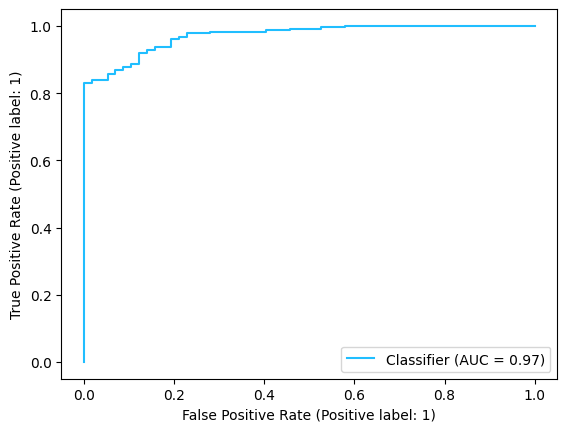

In [40]:
RocCurveDisplay.from_predictions(labels, pos_probs, color='#20BEFF')

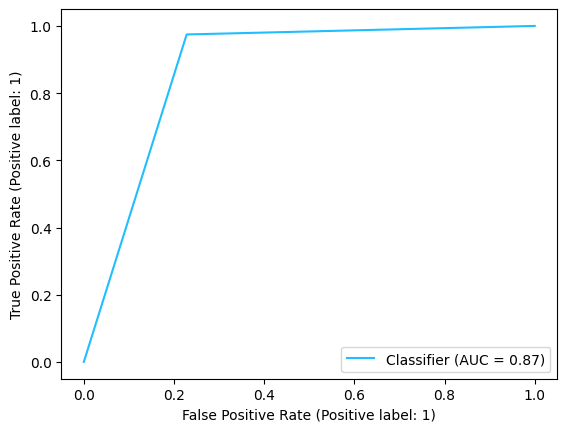

In [28]:
RocCurveDisplay.from_predictions(labels, pos_probs, color='#20BEFF')

(array([ 40.,   0.,   5.,   5.,   0.,   0.,   2.,   9.,   1., 231.]),
 array([0.13056744, 0.20445433, 0.27834123, 0.35222813, 0.42611503,
        0.50000192, 0.57388882, 0.64777572, 0.72166261, 0.79554951,
        0.86943641]),
 <BarContainer object of 10 artists>)

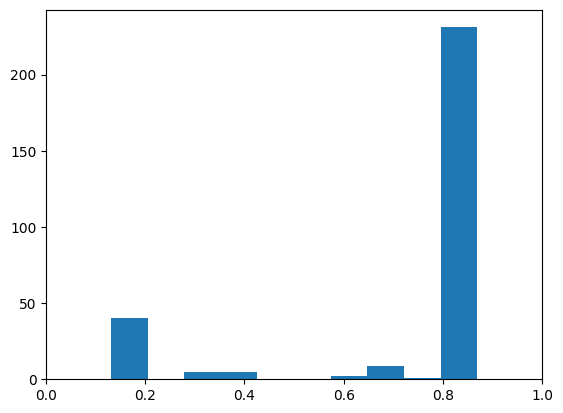

In [45]:
plt.xlim(0,1)
plt.hist(pos_probs)

(array([ 39.,   1.,   2.,   4.,   5.,   1.,   5.,   5.,   4., 227.]),
 array([1.29243577e-04, 1.00112312e-01, 2.00095385e-01, 3.00078452e-01,
        4.00061518e-01, 5.00044584e-01, 6.00027680e-01, 7.00010717e-01,
        7.99993813e-01, 8.99976850e-01, 9.99959946e-01]),
 <BarContainer object of 10 artists>)

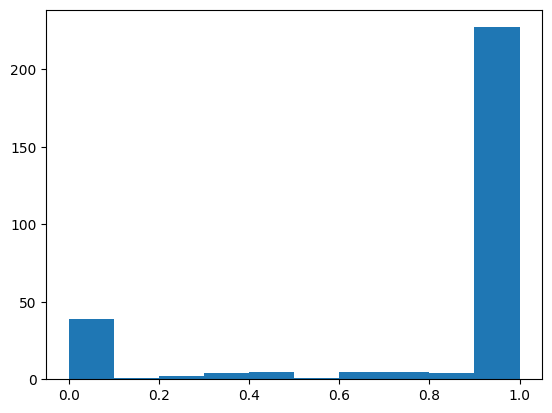

In [35]:
plt.hist(pos_probs)